<a href="https://colab.research.google.com/github/ajeetranaut/Assignment/blob/master/Ecommerce_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP: Text Classification

##Problem Statement 
Classify the description of E-commerce products into 4 categories by implementing any NLP approach for analysis and modeling on the provided dataset. The objective is to recognize whether the given description is related to Electronics (0), Households (1), Books (2), or Clothing & Accessories (3) products. Focus majorly on unique preprocessing techniques.
Dataset: Ecommerce Text Classification

### Uploading data 

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ecommerceDataset.csv to ecommerceDataset.csv


In [5]:
import pandas as pd
# Select the dataset for the analysis
df = pd.read_csv("ecommerceDataset.csv",names=["category", "text"])
#df = df[["category", "text"]]

# Show the data
df.head()

,category,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


##Analyze Data

In [6]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["category"].value_counts())
print(40*'-')
nr_categories = len(df["category"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 50425
----------------------------------------
Split by category:
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: category, dtype: int64
----------------------------------------
Number of categories: 4


We get a total number of entries of 50425, which are relatively evenly split across four categories.

In [72]:
# You can adjust n:
n=100
print('Category: ',df['category'][n])
print(200*'-')
print('Text:')
print(df['text'][n])

Category:  Household
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text:
Embroidery Kit for Beginners DIY Kit Total 15 Iteam This embroidery kit is consists of all the basic items that a beginner will require to learn embroidery. This kit can also be a perfect gift for your loved ones.


### Prepare Data

In [71]:
##pip install transformers

We introduce a function that will allow to:

convert to lower cases, remove special characters, …

tokenize (i.e. convert from strings to lists of words)

remove stopwords (i.e. remove common words that bring noise to the system, like ‘a’, ‘the’, …)

stemm (i.e. remove -ing, -ly, …, like convert ‘making’ to ‘make’, so that words with same meaning are identified as being the same)

lemmatize (i.e convert the word into a root word, for example ‘feet’ becomes ‘foot’)

In [15]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# Use stopwords list from nltk
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text
# Let's apply this function to the whole corpus
df["text_clean"] = df["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()


,category,text,text_clean
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood 30 inch x 10 i...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic 135...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...


### Split into Train and Test data

In [21]:
# Renaming, Input -> X, Output -> y
X = df['text_clean']
y = df['category']
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['category'])

### split by category

In [22]:
y_train.value_counts()/y.value_counts()

Household                 0.699995
Books                     0.700000
Electronics               0.699934
Clothing & Accessories    0.700035
Name: category, dtype: float64

##TF-IDF Model

In [23]:
corpus = X_train
# Initizalize the vectorizer with max nr words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)
TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

TfidfVectorizer(max_features=15000, ngram_range=(1, 2))

### We build the model as a pipeline, consisting of:

vectorization

classifier

In [24]:
classifier_tfidf = LogisticRegression()
model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", classifier_tfidf)])

start_time = datetime.now()
model_tfidf.fit(X_train, y_train)
end_time = datetime.now()

training_time_tfidf = (end_time - start_time).total_seconds()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [25]:
predicted_train_tfidf = model_tfidf.predict(X_train)
accuracy_train_tfidf = accuracy_score(y_train, predicted_train_tfidf)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = model_tfidf.predict(X_test)
accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

print('Training time: {:.1f}s'.format(training_time_tfidf))

Accuracy Training data: 97.7%
Accuracy Test data: 96.6%
Training time: 18.4s


###  Both training and test accuracy are similar, so the model is not overfitted.

In [26]:
print('Classes of the model: ',classifier_tfidf.classes_)
print(80*'-')
print('Shape of the coefficients of the model (categories x vocabulary size): ',classifier_tfidf.coef_.shape)
print(80*'-')
NN = 10
# Get the 10 (here: NN, which you can adjust yourself) ids of the words with highest weights per category
top_words = np.argsort(classifier_tfidf.coef_,axis=1)[:,-NN:]

# Get the vocabulary of the model (mapping of words to ids):
voc = vectorizer_tfidf.vocabulary_
# Get the inverse vocabulary to map the ids of the words to the words:
inv_voc = {v: k for k, v in voc.items()}

# Get for each category (=class) the top ten words
for n, w in enumerate(classifier_tfidf.classes_):
    t = w + ': '
    for i in range(NN):
        t += inv_voc[top_words[n,i]]
        if i!=NN:
            t+=', '
    print(t)
    print(80*'-')

Classes of the model:  ['Books' 'Clothing & Accessories' 'Electronics' 'Household']
--------------------------------------------------------------------------------
Shape of the coefficients of the model (categories x vocabulary size):  (4, 15000)
--------------------------------------------------------------------------------
Books: engineering, game, action, review, story, edition, guide, fishing, author, book, 
--------------------------------------------------------------------------------
Clothing & Accessories: unisex, fabric, bra, wear, sunglass, girl, boy, cotton, men, woman, 
--------------------------------------------------------------------------------
Electronics: tablet, screen, phone, mount, black, speaker, cable, lens, laptop, camera, 
--------------------------------------------------------------------------------
Household: vacuum, curtain, steel, chair, room, kitchen, door, plastic, set, home, 
-------------------------------------------------------------------------

### The model seems to work well

## Deep Learning
Here we will use Deep Learning Algorithms to classify the E-commerce Text

Training and test data is defined in a different way than for TF-IDF: we will use the non-processed text. The labelling cannot be handled as text but has to be converted into a one-hot vector, because of technical reasons (to the best of my knowledge, this is simply not implemented in TensorFlow). Then we split into training and test data, same as we did for TF-IDF.

In [32]:
# Renaming, Input -> X, Output -> y
X_tf = df['text'].astype(str)
y_tf_class = df['category']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_tf_class)
y_tf = lab.transform(y_tf_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + y_tf_class[n] + ' is ', y_tf[n])

# Split into training and test data
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, random_state=42, stratify=df['category'])


Coding of labels into a one-hot vector: Household is  [0 0 0 1]


The text, a sequence of words, needs to be converted to a sequence of numbers. We tokenize the text using TensorFlow’s tokenizer.

After initializing the tokenizer, we fit it on the training data.

In [34]:
corpus = X_tf_train
max_words = 15000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

Let’s use the tokenizer to convert the training data (a sequence of words) into a sequence of numbers representing the words. We then pad sequences using TensorFlow’s pad_sequences. We define a limit to the length of the sequences. Any text with more words than allowed will be cut.

We look at the shape of the training data after processing it, and illustrate it with a specific example.

In [35]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (35297, 200)
----------------------------------------------------------------------------------------------------
Example:  [12348  2967  4039   994  1634     1   137   685     9   815  1819  3550
   197   457  1403  1022  1022  2968  1693  2095  2569   994    52   884
  1155  6369   847   215  9337   603    73    73 14708   424  5288   957
  8586     1   220   815   687   957  3014   879   127  8309   315   515
  6728  1285   125   434   266     1   957    49  1323   973   957 14123
   957     1   957  3105   187  2889   188   434   220   434  3637     1
  1078   768     1  1078   187 14124  4400   540   326  3911   451     7
   957  5561   315   194    34  2033     5   399   182  2382   808     3
  1487   973  8309   451    15    31  8309   315   540    84   451  5228
  4150  1561   122   977   631  6086   220  1441  1042  8310  2250   125
  1441  1042  4656   649  4560 11397   268  1713    21   551     1  6816
     1     1 12349  2591  8868 13615     1     1  9527     1 1033

Each word is now represented by a number (an index). We want to represent it by a vector which represents it best, leveraging on pre-learned information.

This is done using Word2Vec, which we have described above. We will not train ourselves this word representation but download an existing representation, from the library gensim. This may take several minutes. Once this word representation is available, we map it to our tokenization.

In [36]:
# This may take several minutes
w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
w2v['hello'].shape

# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

[==================================================] 100.0% 1662.8/1662.8MB downloaded


### Model Building

we build the model. We use:

Input layer: to tell the model which input format to expect, so that the model knows what to expect

Embedding: we transform the input (a sequence of word indices) into a sequence of embedded words (a sequence of vectors of size 300), using the downloaded Word2Vec matrix

LSTM layer: we use an LSTM layer that goes in both directions (forward and backward), to have maximal information available. The output of this layer (that is pushed to the next layer) is the output of the last word (on the right for the forward LSTM, on the left for the backward LSTM). We set the size of the output vector to 15 (which is somewhat arbitrary). Combining both outputs (forward and backward), we get a vector of size 30

Dropout layer: for regularization

Dense layer (with relu activation function, with 64 neurons): to solve the specific problem of classification

Dense layer (with softmax activation function): for a probability distribution for each label

In [37]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

### Model

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          4500300   
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               37920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 4)                 260       
                                                             

### Train the model

In [39]:
start_time = datetime.now()
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/10
552/552 [==============================] - 145s 254ms/step - loss: 0.3675 - accuracy: 0.8917 - val_loss: 0.2254 - val_accuracy: 0.9385
Epoch 2/10
552/552 [==============================] - 142s 257ms/step - loss: 0.2308 - accuracy: 0.9369 - val_loss: 0.1904 - val_accuracy: 0.9499
Epoch 3/10
552/552 [==============================] - 141s 255ms/step - loss: 0.1851 - accuracy: 0.9499 - val_loss: 0.1886 - val_accuracy: 0.9529
Epoch 4/10
552/552 [==============================] - 141s 255ms/step - loss: 0.1635 - accuracy: 0.9552 - val_loss: 0.1644 - val_accuracy: 0.9580
Epoch 5/10
552/552 [==============================] - 141s 255ms/step - loss: 0.1527 - accuracy: 0.9584 - val_loss: 0.1578 - val_accuracy: 0.9601
Epoch 6/10
552/552 [==============================] - 140s 255ms/step - loss: 0.1340 - accuracy: 0.9625 - val_loss: 0.1496 - val_accuracy: 0.9609
Epoch 7/10
552/552 [==============================] - 141s 255ms/step - loss: 0.1359 - accuracy: 0.9621 - val_loss: 0.1643 -

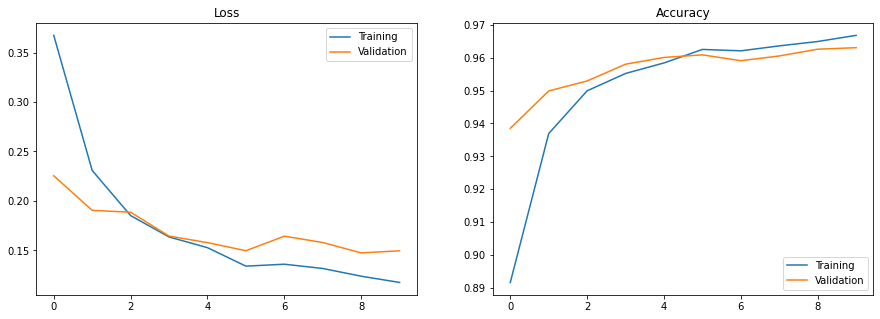

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [57]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 96.7%
Accuracy Test data: 96.3%
Training time: 1465.7s


we observe that this sophisticated model gets a  accuracy which is near to  the TF-IDF model.

In [99]:
method = ['TF-IDF', 'RNN']
accuracy = [accuracy_tfidf, accuracy_rnn]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
training_time = [round(training_time_tfidf,1), round(training_time_rnn,1)]
training_time_rounded = [round(tt,1) for tt in training_time]
training_time = np.array(training_time)
training_time_x = list(training_time /min(training_time))
training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

,Method,Accuracy,Training Time [s],Training Time [x]
0,TF-IDF,96.6%,18.4,1.0x
1,RNN,96.3%,1465.7,79.7x


This classification is a simple problem. A simple model like the linear TF-IDF model already provides a very good accuracy. Using more complex models does not improve accuracy.